# Single Pixel Inversion from SST/CRISP Observations of the M1.1 Two-ribbon Flare SOL20140906T17:09 using RADYNVERSION

This is an example notebook to show how to prep observed spectral lines of H$\alpha$ and Ca II $\lambda$8542 from SST/CRISP observations and invert them using the RADYNVERSION algorithm.

The observations here are taken from a time just after the flare onset (as described in Osborne et al 2019). We show the inversion for a pixel on the flare ribbon as well as a point far from the flare ribbon to show that we can invert for well-constrained atmospheres even in the low and high energy regimes.

Pacakges needed to run this notebook are:

* `PyTorch`
* `numpy`
* `matplotlib`
* `scikit-image`
* `palettable`
* `RadynPy`
* `crisPy`

Inversions can be done without `palettable` but we use this to pick the colourmap for the images. Inversions can also be done without `crisPy` but I like to use this data class to make it easier to manipulate images and spectral lines from SST/CRISP data.

In [1]:
%matplotlib notebook
# %config InlineBackend.figure_format = "retina"

from utils import * #utils.py is included in the GitHub for RADYNVERSION and should also be available as a submodule of RadynPy: https://github.com/Goobley/radynpy
import sys
sys.path.append("/home/armstrong/crisPy")
from instrument import CRISP #the SST/CRISP data class is included in the GitHub repository crisPy: https://github.com/rhero12/crisPy
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import match_template
from palettable.cmocean.sequential import Solar_20
import html
from IPython.core.display import display,HTML

display(HTML("<style>.container{ width:100% !important;}</style>"))
model_pth = "Radynversion_1.0.0.pth.tar"
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if a GPU is available use the GPU
sol_cm = Solar_20.mpl_colormap
angstrom = html.unescape("&#8491;")
plt.rcParams.update({"font.size" : 11})

There is a function from `utils.py` which creates the model and returns the height grid that our atmospheric profiles will be plotted on.

In [2]:
model, z = create_model(model_pth,dev)

=> loading checkpoint 'Radynversion_1.0.0.pth.tar'
Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (384,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (384,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (384,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (384,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (384,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (384,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (384,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (384,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (384,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (384,)

=> loaded checkpoint 'Radynversion_1.0.0.pth.tar' (total number of epochs trained for 11400)


Next we define the fits files containing the data and prep the data for plotting. The points in the code below are the pixels to be inverted and the coordinates are given in units of arcseconds.

In [3]:
ca_file = "example_data/crisp_l2_20140906_152724_8542_r00459.fits"
ha_file = "example_data/crisp_l2_20140906_152724_6563_r00459.fits"

ha_central_idx = 7
ca_central_idx = 12
ha_hw = 1.4
ca_hw = 1.0 #1.0 because RADYN has a 1A half-width for calcium

crisp = CRISP(ca_file=ca_file,ha_file=ha_file,rotate=True)

im_centre_ca = crisp.data.ca[12]
im_centre_ha = crisp.data.ha[7]
im_bwing_ca = crisp.data.ca[4]
im_bwing_ha = crisp.data.ha[0]
im_rwing_ca = crisp.data.ca[20]
im_rwing_ha = crisp.data.ha[14]
px_width = crisp.header.ca["CDELT1"]
point_1_ha = np.array([30.72,37.47])
point_2_ha = np.array([50.37,3.73])
point_1_ca = np.array([30.22,36.47])
point_2_ca = np.array([49.87,2.73])

<IPython.core.display.Javascript object>


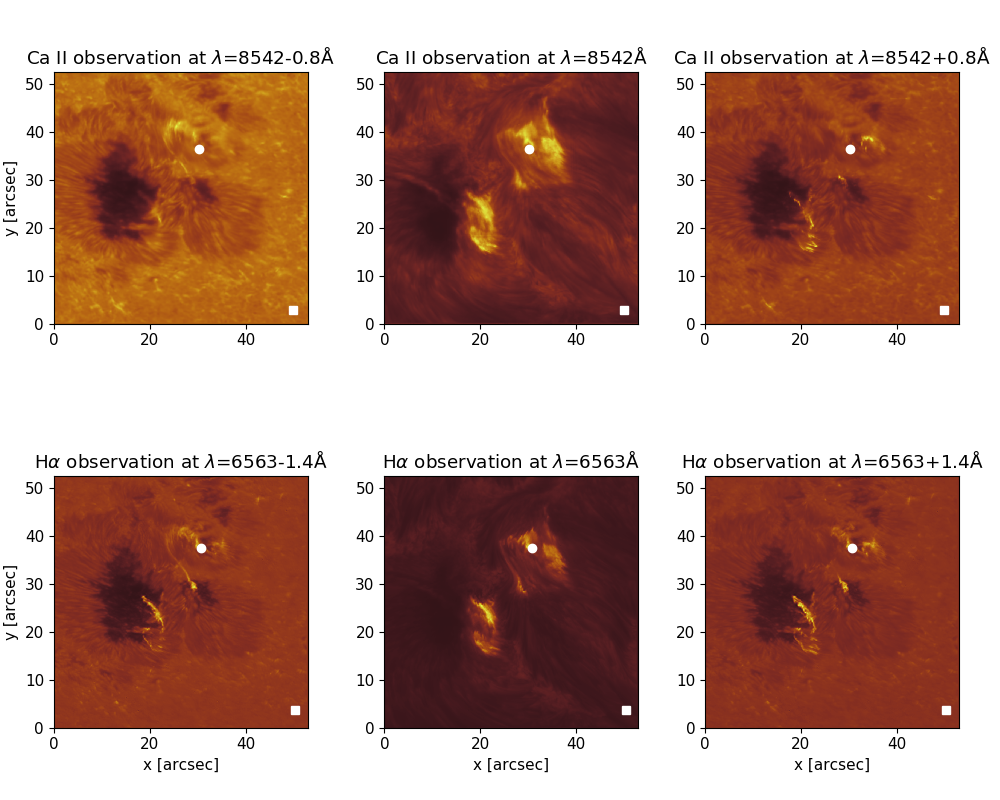

In [4]:
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(10,8),constrained_layout=True)
ax[0,0].imshow(im_bwing_ca,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[0,0].set_title(r"Ca II observation at $\lambda$=8542-0.8"+angstrom)
ax[0,0].set_ylabel("y [arcsec]")
ax[0,0].plot(point_1_ca[0],point_1_ca[1],"wo")
ax[0,0].plot(point_2_ca[0],point_2_ca[1],"ws")
ax[0,1].imshow(im_centre_ca,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[0,1].set_title(r"Ca II observation at $\lambda$=8542"+angstrom)
ax[0,1].plot(point_1_ca[0],point_1_ca[1],"wo")
ax[0,1].plot(point_2_ca[0],point_2_ca[1],"ws")
ax[0,2].imshow(im_rwing_ca,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[0,2].set_title(r"Ca II observation at $\lambda$=8542+0.8"+angstrom)
ax[0,2].plot(point_1_ca[0],point_1_ca[1],"wo")
ax[0,2].plot(point_2_ca[0],point_2_ca[1],"ws")
ax[1,0].imshow(im_bwing_ha,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[1,0].set_title(r"H$\alpha$ observation at $\lambda$=6563-1.4"+angstrom)
ax[1,0].set_ylabel("y [arcsec]")
ax[1,0].set_xlabel("x [arcsec]")
ax[1,0].plot(point_1_ha[0],point_1_ha[1],"wo")
ax[1,0].plot(point_2_ha[0],point_2_ha[1],"ws")
ax[1,1].imshow(im_centre_ha,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[1,1].set_title(r"H$\alpha$ observation at $\lambda$=6563"+angstrom)
ax[1,1].set_xlabel("x [arcsec]")
ax[1,1].plot(point_1_ha[0],point_1_ha[1],"wo")
ax[1,1].plot(point_2_ha[0],point_2_ha[1],"ws")
ax[1,2].imshow(im_rwing_ha,extent=[0,px_width*im_centre_ca.shape[1],0,px_width*im_centre_ca.shape[0]],origin="bottom",cmap=sol_cm)
ax[1,2].set_title(r"H$\alpha$ observation at $\lambda$=6563+1.4"+angstrom)
ax[1,2].set_xlabel("x [arcsec]")
ax[1,2].plot(point_1_ha[0],point_1_ha[1],"wo")
ax[1,2].plot(point_2_ha[0],point_2_ha[1],"ws")

Here we extract the spectral lines from the data class and interpolate them linearly onto the RADYN wavelength grid so we can invert the profiles. The profiles are also normalised to the maximum value between the lines.

<IPython.core.display.Javascript object>


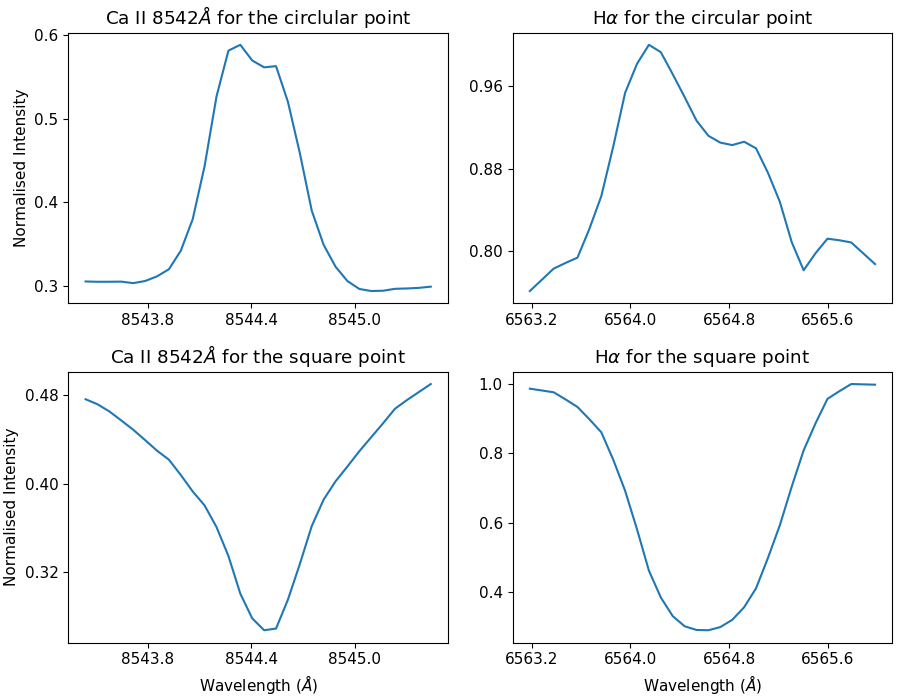

In [5]:
ca_1 = crisp.intensity_vector(point_1_ca,coord_type="arcsec")
ha_1 = crisp.intensity_vector(point_1_ha,coord_type="arcsec",line="ha")
ca_2 = crisp.intensity_vector(point_2_ca,coord_type="arcsec")
ha_2 = crisp.intensity_vector(point_2_ha,coord_type="arcsec",line="ha")
ca_centre_wvl = crisp.header.ca["TWAVE1"]
ca_wvls = crisp.data.ca_wvls
ha_centre_wvl = crisp.header.ha["TWAVE1"]
ha_wvls = crisp.data.ha_wvls

new_ca_1 = interp_to_radyn_grid(ca_1,ca_centre_wvl,ca_hw,ca_wvls)
new_ha_1 = interp_to_radyn_grid(ha_1,ha_centre_wvl,ha_hw,ha_wvls)
new_ca_2 = interp_to_radyn_grid(ca_2,ca_centre_wvl,ca_hw,ca_wvls)
new_ha_2 = interp_to_radyn_grid(ha_2,ha_centre_wvl,ha_hw,ha_wvls)

new_ca_1, new_ha_1 = normalise(new_ca_1,new_ha_1)
new_ca_2, new_ha_2 = normalise(new_ca_2,new_ha_2)

fig, ax = plt.subplots(2,2,figsize=(9,7),constrained_layout=True)
ax[0,0].plot(new_ca_1[0],new_ca_1[1])
ax[0,0].set_title(r"Ca II 8542$\AA{}$ for the circlular point")
ax[0,0].set_ylabel("Normalised Intensity")
ax[0,1].plot(new_ha_1[0],new_ha_1[1])
ax[0,1].set_title(r"H$\alpha$ for the circular point")
ax[1,0].plot(new_ca_2[0],new_ca_2[1])
ax[1,0].set_title(r"Ca II 8542$\AA{}$ for the square point")
ax[1,0].set_ylabel("Normalised Intensity")
ax[1,0].set_xlabel(r"Wavelength ($\AA{}$)")
ax[1,1].plot(new_ha_2[0],new_ha_2[1])
ax[1,1].set_title(r"H$\alpha$ for the square point")
ax[1,1].set_xlabel(r"Wavelength ($\AA{}$)")
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(4))

Next we do the inversions with the `inversion` function where `batch_size` denotes how many inversions to be done. The plots are then made with the `inversion_plots` function. The plots of the atmospheric parameters are two dimensional histograms with the higher densities in the bins corresponding to the likelihood of the atmospheric parameters at the corresponding height. The plots of the spectral lines have dotted blue lines indicating the true line profiles and the 2D histogram bins correspond to the output spectral lines when the inverted atmospheric profiles are passed back through the network in the forwards direction.

In [6]:
res = inversion(model,dev,new_ca_1,new_ha_1,batch_size=20000)

<IPython.core.display.Javascript object>


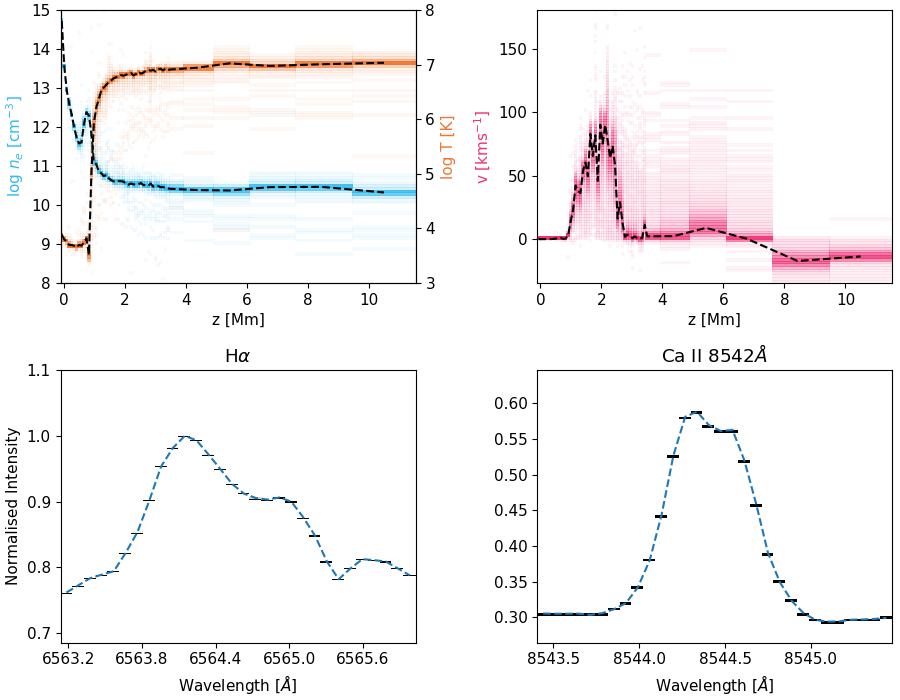

In [10]:
inversion_plots(res,z,new_ca_1,new_ha_1)

In [8]:
res_2 = inversion(model,dev,new_ca_2,new_ha_2,20000)

<IPython.core.display.Javascript object>


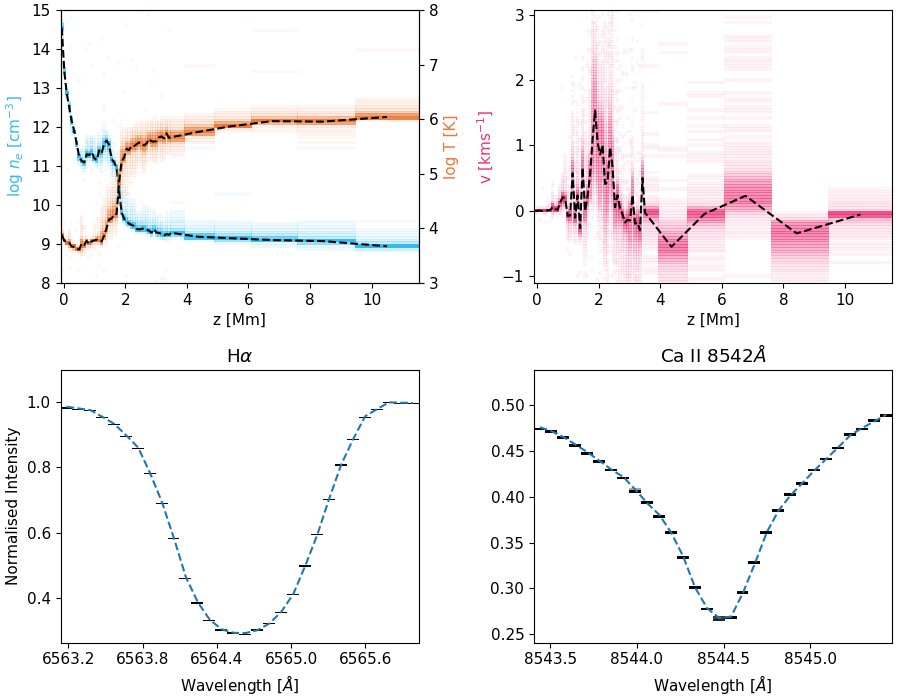

In [11]:
inversion_plots(res_2,z,new_ca_2,new_ha_2)